In [2]:
#!pip install tensorflow
# !pip install -U scikit-learn
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 30.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
from PIL import Image
import numpy as np
import pandas as pd
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [6]:
# Kích thướng mỗi frame
IMAGE_WIDTH,  IMAGE_HEIGHT = 160, 120
# số lượng frame sẽ lấy ở mỗi video
SEQUENCE_LENGTH = 20
# Những hành động sẽ nhận dạng
CLASSES_LIST = ['Your', 'Love', 'Sleep', 'Name',
                'What', 'Read', 'I', 'Bye', 'You', 'Eat', 'Hello']

# Link thư mục chứa video train
DATASET_DIR = './drive/MyDrive/PBL5'


In [ ]:
# files_list =  os.listdir(DATASET_DIR)
# files_list

In [ ]:
# features = np.array([])
# labels = np.array([])
# for file_name in files_list:
#     print('Reading ', file_name, '. ... ..')
#     video_file_path = os.path.join(DATASET_DIR, file_name)
#     dataset = np.load(video_file_path)
#     feature = dataset['features']
#     label = dataset['labels']
#     print(feature.shape)
#     print(features.shape)
#     if features.any():
#         features = np.concatenate((features, feature), axis=0)
#     else:
#         features = feature
#     if labels.any():
#         labels = np.concatenate((labels, label), axis=0)
#     else:
#         labels = label


In [ ]:
dataset = np.load(f'{DATASET_DIR}/dataset_2.npz')
features=dataset['features']
labels=dataset['labels']
video_files_paths=dataset['video_files_paths']

In [ ]:
features.shape

(209, 20, 120, 160, 3)

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [7]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [8]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 118, 158, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 59, 79, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 59, 79, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 57, 77, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 29, 39, 8)    0         
 3D)                                                             
                                                      

In [ ]:
# plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

In [ ]:
# !pip install pydot

In [ ]:
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# # Compile the model and specify loss function, optimizer and metrics values to the model
# convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# # Start training the model.
# convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
 	
# # Evaluate the trained model.
# model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [ ]:
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# # Define the string date format.
# # Get the current Date and Time in a DateTime Object.
# # Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
# model_file_name = f'{DATASET_DIR}/convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# # Save your Model.
# convlstm_model.save(model_file_name)

In [ ]:
# plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
# plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 160, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 30, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 30, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 30, 40, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 7, 10, 32)    0

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model.load_weights(f'{DATASET_DIR}/LRCN_model___Date_Time_2023_03_23__17_07_44___Loss_0.8039475679397583___Accuracy_0.7857142686843872.h5') 
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 300, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/300
34/34 [==============================] - 35s 954ms/step - loss: 0.1734 - accuracy: 0.9774 - val_loss: 1.3597 - val_accuracy: 0.6765
Epoch 2/300
34/34 [==============================] - 34s 1s/step - loss: 0.1387 - accuracy: 0.9925 - val_loss: 1.3814 - val_accuracy: 0.7059
Epoch 3/300
34/34 [==============================] - 33s 976ms/step - loss: 0.1113 - accuracy: 1.0000 - val_loss: 1.2916 - val_accuracy: 0.6765
Epoch 4/300
34/34 [==============================] - 33s 940ms/step - loss: 0.1126 - accuracy: 0.9925 - val_loss: 1.3513 - val_accuracy: 0.6471
Epoch 5/300
34/34 [==============================] - 32s 954ms/step - loss: 0.1623 - accuracy: 0.9699 - val_loss: 1.0705 - val_accuracy: 0.7059
Epoch 6/300
34/34 [==============================] - 31s 926ms/step - loss: 0.1600 - accuracy: 1.0000 - val_loss: 1.3404 - val_accuracy: 0.6471
Epoch 7/300
34/34 [==============================] - 41s 1s/step - loss: 0.1012 - accuracy: 1.0000 - val_loss: 1.1807 - val_accuracy: 0.735

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 8s 1s/step - loss: 0.8039 - accuracy: 0.7857


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'{DATASET_DIR}/LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

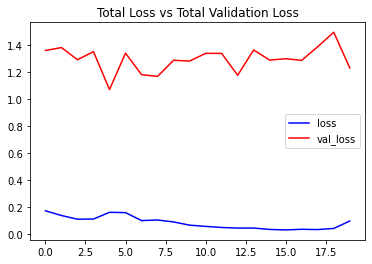

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

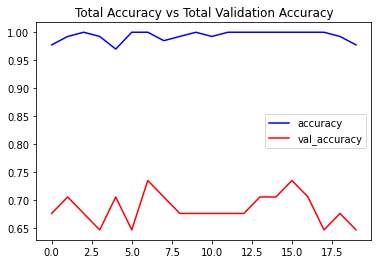

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
model_evaluation_accuracy

0.7857142686843872

In [ ]:
DATASET_DIR